This project successfully demonstrates the implementation of a Deep Q-Network (DQN) for reinforcement learning in the CartPole-v1 environment. By leveraging experience replay and a target network, the agent learns to balance the pole over a series of episodes. Over time, the average reward increases, showing that the agent is improving its policy through training.

Key Outcomes:

1. Implemented a neural network-based Q-function approximator.
2. Used experience replay and a target network for stable learning.
3. Achieved sustained high rewards over training episodes.


In [ ]:
!pip install gym==0.26.2
!pip install numpy>=1.24

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 18.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827728 sha256=e3563693ba0770292e97577aed532c05683f3fe038e81db124a4c0ddb3f2ce10
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
import gym
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [ ]:
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
memory_size = 2000
batch_size = 32
episodes = 500
target_update = 10

In [ ]:
memory = deque(maxlen=memory_size)

definig the environment

In [ ]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

state, _ = env.reset()
state = np.reshape(state, [1, state_size])

building Q-network

In [ ]:
def build_model():
    model = Sequential()
    model.add(Dense(24, input_dim=state_size, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

model = build_model()
target_model = build_model()
target_model.set_weights(model.get_weights())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epsilon-greedy action selection

In [ ]:
def act(state):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    q_values = model.predict(state, verbose=0)
    return np.argmax(q_values[0])

In [ ]:
# Replay and train
def replay():
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    states = np.vstack([e[0] for e in minibatch])
    targets = model.predict(states, verbose=0)
    next_states = np.vstack([e[3] for e in minibatch])
    target_vals = target_model.predict(next_states, verbose=0)
    for i, (_, action, reward, _, done) in enumerate(minibatch):
        if done:
            targets[i][action] = reward
        else:
            targets[i][action] = reward + gamma * np.amax(target_vals[i])
    model.fit(states, targets, epochs=1, verbose=0)

In [ ]:
reward_history = []

for e in range(episodes):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    terminated = False
    truncated = False

    while not terminated:
        action = act(state)
        next_state, reward, terminated, truncated, _  = env.step(action) # unpacking terminated and truncated separately
        next_state = np.reshape(next_state, [1, state_size])
        # Use terminated or truncated to indicate the end of episode
        done = terminated or truncated
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        replay()

    reward_history.append(total_reward)

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if e % target_update == 0:
        target_model.set_weights(model.get_weights())

    print(f"Episode: {e+1}/{episodes}, Score: {total_reward}, Epsilon: {epsilon:.3f}")

Episode: 1/500, Score: 27.0, Epsilon: 0.995
Episode: 2/500, Score: 13.0, Epsilon: 0.990
Episode: 3/500, Score: 26.0, Epsilon: 0.985
Episode: 4/500, Score: 50.0, Epsilon: 0.980
Episode: 5/500, Score: 14.0, Epsilon: 0.975
Episode: 6/500, Score: 9.0, Epsilon: 0.970
Episode: 7/500, Score: 48.0, Epsilon: 0.966
Episode: 8/500, Score: 12.0, Epsilon: 0.961
Episode: 9/500, Score: 19.0, Epsilon: 0.956
Episode: 10/500, Score: 34.0, Epsilon: 0.951
Episode: 11/500, Score: 15.0, Epsilon: 0.946
Episode: 12/500, Score: 21.0, Epsilon: 0.942
Episode: 13/500, Score: 14.0, Epsilon: 0.937
Episode: 14/500, Score: 30.0, Epsilon: 0.932
Episode: 15/500, Score: 13.0, Epsilon: 0.928
Episode: 16/500, Score: 38.0, Epsilon: 0.923
Episode: 17/500, Score: 26.0, Epsilon: 0.918
Episode: 18/500, Score: 28.0, Epsilon: 0.914
Episode: 19/500, Score: 28.0, Epsilon: 0.909
Episode: 20/500, Score: 22.0, Epsilon: 0.905
Episode: 21/500, Score: 24.0, Epsilon: 0.900
Episode: 22/500, Score: 58.0, Epsilon: 0.896
Episode: 23/500, Sco

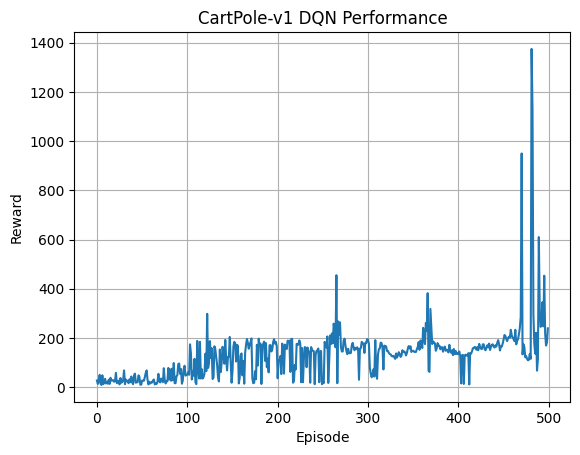

In [ ]:
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("CartPole-v1 DQN Performance")
plt.grid()
plt.show()

In [ ]:
average_reward = sum(reward_history) / len(reward_history)
print(f"Average Reward over {episodes} episodes: {average_reward:.2f}")

Average Reward over 500 episodes: 129.53


The agent learns to balance the pole, increasing its average reward over time through training. Training stabilizes after a number of episodes.

###How to improve?

1. Implement Double or Dueling DQN
2. Use Prioritized Experience Replay
3. Add video rendering of agent performance
4. Try on more complex environments (e.g., MountainCar, LunarLander)